Adjust pre-processing function, to make it suitable for WaterInsight input.

In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 scikit-learn==1.4.2 tensorflow==2.16.1 joblib==1.4.2 openpyxl==3.1.2


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import os
import joblib


def selective_quantile_loss(tau=0.7, threshold=0.95):
    def loss(y_true, y_pred):
        # Mask: 1 if y_true > threshold (in standard scaled data), else 0
        mask = K.cast(y_true > threshold, dtype='float32')
        
        # Quantile loss (asymmetric) applied only to peaks
        error = y_true - y_pred
        quantile = K.maximum(tau * error, (tau - 1) * error)
        peak_loss = mask * quantile

        # Optional: apply MSE to non-peak values
        mse_loss = (1.0 - mask) * K.square(error)

        return K.mean(peak_loss + mse_loss)
    return loss


# Load Data with Hourly Timestamps
def load_data(file_path):
    df = pd.read_csv(file_path, usecols=["Timestamp", "Varibale Value"], low_memory=False)

    # Convert timestamp
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %H:%M")
    df = df.sort_values(by='Timestamp') 

    # Ensure variable column is numeric
    df["Varibale Value"] = pd.to_numeric(df["Varibale Value"], errors="coerce")

    return df


# Aggregate hourly data into assigned time step
def aggregate_to_nhourly_last_timestamp(df, aggregation_period=3):
    # Sort and reset index
    df = df.sort_values(by='Timestamp').reset_index(drop=True)

    # Group by the specified aggregation period
    group_size = aggregation_period
    num_groups = len(df) // group_size

    result = []
    for i in range(num_groups):
        group = df.iloc[i*group_size : (i+1)*group_size]
        avg_1 = group.iloc[:, 1].mean()  # First value column
        label_2 = group.iloc[0,2] #label
        timestamp = group.iloc[0]["Timestamp"]  # first in the group
        result.append({
            "Timestamp": timestamp,
            df.columns[1]: avg_1,
            df.columns[2]: label_2
        })

    return pd.DataFrame(result)

# include labels if any, otherwise it follows the simplest aggregation
def create_sequences(data, window_size, lead_time, labels=None):
    X, Y, seq_labels = [], [], []

    n = len(data)
    for i in range(n - window_size - lead_time + 1):
        # Check input window and output (target) labels
        if labels is not None:
            input_labels = labels[i : i + window_size]
            output_labels = labels[i + window_size : i + window_size + lead_time]
            all_labels = np.concatenate([input_labels, output_labels])
            if not np.all(all_labels == all_labels[0]):
                continue  # Only keep "pure" sequences
            this_label = all_labels[0]
        else:
            this_label = None

        X.append(data[i:i+window_size])
        Y.append(data[i+window_size:i+window_size+lead_time].flatten())
        if labels is not None:
            seq_labels.append(this_label)

    if labels is not None:
        return np.array(X), np.array(Y), np.array(seq_labels)
    else:
        return np.array(X), np.array(Y)

# Create Input-Output Sequences
def preprocess_data(df, column='Varibale Value', window_size=48, lead_time=16):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[[column]])  # Fit-transform on the entire column

    # Generate sequences
    X, Y = create_sequences(scaled_data, window_size, lead_time)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Ensure LSTM input shape

    # Fix `Y_unscaled` to match `Y_scaled`
    X_unscaled, Y_unscaled = create_sequences(df[column].values.reshape(-1, 1),window_size, lead_time)

    # Align timestamps with Y_unscaled
    dates_array = df["Timestamp"].values  # Extract timestamps as NumPy array
    _, date_sequences = create_sequences(dates_array.reshape(-1, 1), window_size, lead_time)  # Keep same shape

    return X, Y, Y_unscaled, date_sequences, scaler  #  Ensure same length


# Split Data
def train_val_test_split(X, Y, Y_unscaled, dates, test_ratio=0.3, val_ratio=0.3):
    # First split: out test set (from the END, as is typical in time series)
    test_split = int(len(X) * (1 - test_ratio))
    X_temp, X_test = X[:test_split], X[test_split:]
    Y_temp, Y_test = Y[:test_split], Y[test_split:]
    Y_unscaled_temp, Y_test_unscaled = Y_unscaled[:test_split], Y_unscaled[test_split:]
    dates_temp, test_dates = dates[:test_split], dates[test_split:]

    # Second split: validation set (from what remains)
    val_split = int(len(X_temp) * (1 - val_ratio))
    X_train, X_val = X_temp[:val_split], X_temp[val_split:]
    Y_train, Y_val = Y_temp[:val_split], Y_temp[val_split:]
    Y_train_unscaled, Y_val_unscaled = Y_unscaled_temp[:val_split], Y_unscaled_temp[val_split:]
    train_dates, val_dates = dates_temp[:val_split], dates_temp[val_split:]

    return (X_train, X_val, X_test, 
            Y_train, Y_val, Y_test,
            Y_train_unscaled, Y_val_unscaled, Y_test_unscaled,
            train_dates, val_dates, test_dates)

# Define LSTM Model

def build_lstm_model(window_size, lead_time):
    model = Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.05),
        LSTM(100, activation='tanh'),
        Dense(lead_time)
    ])
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=selective_quantile_loss(tau=0.7, threshold=0.95))
    return model

# Train Model
def train_model(
    model, X_train, Y_train, X_val, Y_val, epochs=50, batch_size=32, 
    model_path='lstm_flood_model.h5', enable_plotting=True
):
    """
    Train the model using training data and validate on validation set.
    Tracks both best validation loss and most similar train/val loss epochs.
    """
    train_losses, val_losses = [], []
    best_epoch_similarity = None
    best_diff = float('inf')
    best_epoch_val = None
    best_val_loss = float('inf')
    patience = 20  # Early stopping patience

    for epoch in range(epochs):
        history = model.fit(
            X_train, Y_train,
            epochs=1,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            verbose=1
        )
        train_loss = history.history['loss'][0]
        val_loss = history.history['val_loss'][0]
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_val = epoch
            model.save_weights(f'{model_path}_best_val.weights.h5')
            print(f"\nNew best validation loss at epoch {epoch}: Val Loss = {val_loss:.4f}")

        # Best similarity
        diff = abs(train_loss - val_loss)
        if diff < best_diff:
            best_diff = diff
            best_epoch_similarity = epoch
            model.save_weights(f'{model_path}_best_sim.weights.h5')
            print(f"\nNew best similarity at epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping (no improvement in last 'patience' epochs)
        if epoch >= patience:
            if min(val_losses[-patience:]) >= best_val_loss:
                print(f"\nEarly stopping: Validation loss hasn't improved in {patience} epochs")
                break

    # Plot if enabled
    if enable_plotting:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.axvline(best_epoch_similarity, color='red', linestyle='--', label=f'Best Similarity Epoch: {best_epoch_similarity}')
        plt.axvline(best_epoch_val, color='green', linestyle='--', label=f'Best Val Loss Epoch: {best_epoch_val}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Progress\nBest Similarity Epoch: {best_epoch_similarity}, Best Val Loss Epoch: {best_epoch_val}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(model_path.replace('.h5', '_training_history.png'))
        plt.show()   # <--- add this line to show the plot in real time
        plt.close()

    # Return epochs and loss history for further analysis if needed
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_epoch_similarity": best_epoch_similarity,
        "best_diff": best_diff,
        "best_epoch_val": best_epoch_val,
        "best_val_loss": best_val_loss
    }


# Load Trained Model
def load_trained_model(model_path='lstm_flood_model.h5'):
    from tensorflow.keras.utils import get_custom_objects
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")

        # Reconstruct loss with the same parameters
        loss_fn = selective_quantile_loss(tau=0.7, threshold=0.95)
        
        return load_model(model_path, custom_objects={'loss': loss_fn})
    else:
        print("No trained model found. Train a model first.")
        return None


# Forecasting
def forecast(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)  # Convert back to original scale

# Evaluation Metrics
def calculate_nse(actual, predicted):
    return 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

def calculate_kge(actual, predicted):
    r = np.corrcoef(actual.squeeze(), predicted.squeeze())[0, 1]
    beta = np.mean(predicted) / np.mean(actual)
    gamma = np.std(predicted) / np.std(actual)
    return 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Plot Results
def plot_results(actual, predicted, dates):

    # Extract the last lead-time step for comparison
    actual_last = actual[:, -1]  # Last column of actual values
    predicted_last = predicted[:, -1]  # Last column of predictions
    dates_last = dates[:, -1]  # Last timestamp for alignment

    rmse = root_mean_squared_error(actual_last, predicted_last)
    nse_value = calculate_nse(actual_last, predicted_last)
    kge_value = calculate_kge(actual_last, predicted_last)
    
    plt.figure(figsize=(12,6))
    plt.plot(dates_last, actual_last, label='Actual Flow Rate (ML/day)')
    plt.plot(dates_last, predicted_last, label='Predicted Flow Rate (ML/day)', linestyle='dashed')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Flow Rate (ML/day)")
    plt.title(f"Flow Rate Forecasting using LSTM\nRMSE: {rmse:.4f}, NSE: {nse_value:.4f}, KGE: {kge_value:.4f}")
    plt.xticks(rotation=45)
    plt.show()


c:\Users\z5318148\AppData\Local\anaconda3\envs\lstm_flood_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model...
536/536 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - loss: 0.0436 - val_loss: 0.0190

New best validation loss at epoch 0: Val Loss = 0.0190

New best similarity at epoch 0: Train Loss = 0.0243, Val Loss = 0.0190
536/536 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0128 - val_loss: 0.0217
536/536 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - loss: 0.0116 - val_loss: 0.0147

New best validation loss at epoch 2: Val Loss = 0.0147

New best similarity at epoch 2: Train Loss = 0.0116, Val Loss = 0.0147
536/536 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - loss: 0.0110 - val_loss: 0.0161
536/536 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 0.0101 - val_loss: 0.0239
536/536 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - loss: 0.0104 - val_loss: 0.0177
536/536 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - loss: 0.0088 - val_loss: 0.0179
536/536 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - loss: 0.0085 - val_loss: 0.0135

New best validation loss at epoch 7: Val Loss = 0.0135
536/536 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - loss: 0.0

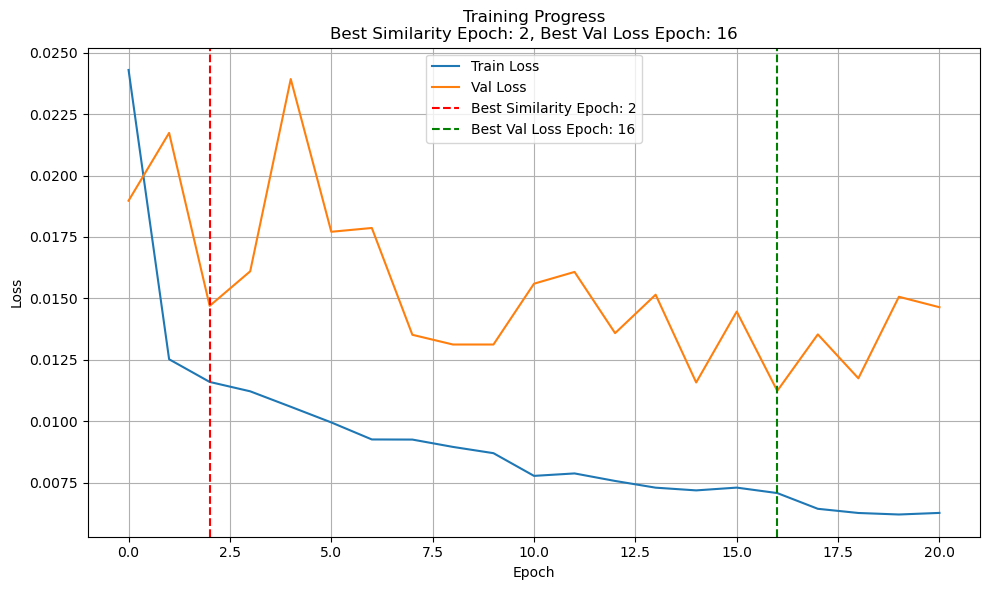

328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
536/536 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step


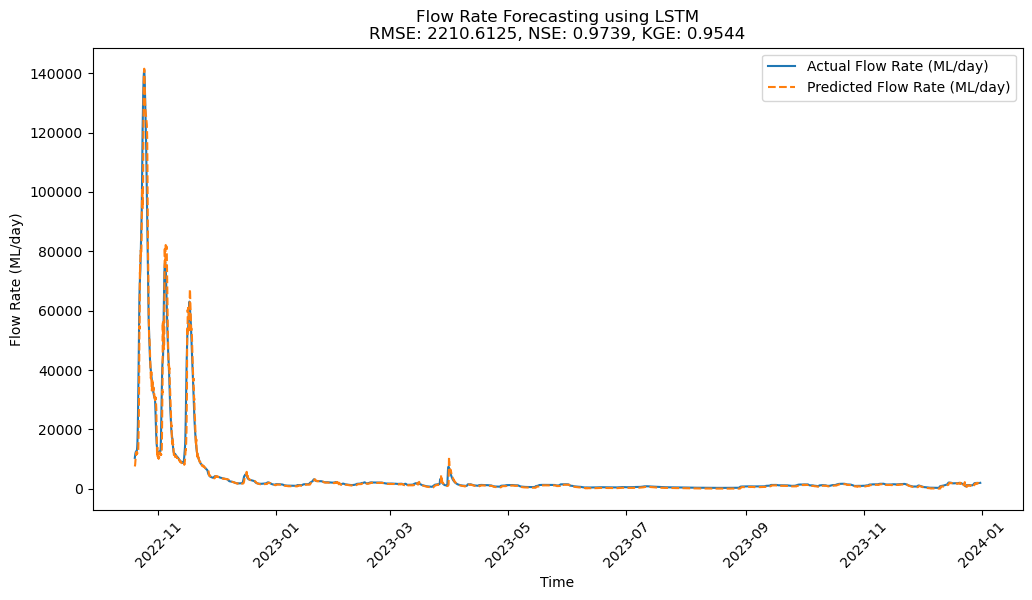

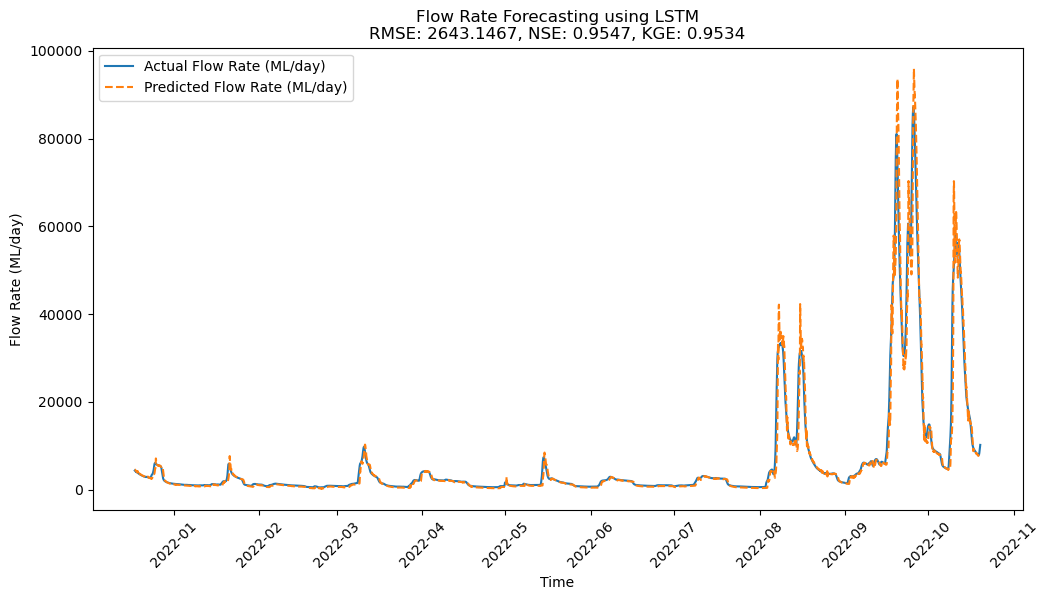

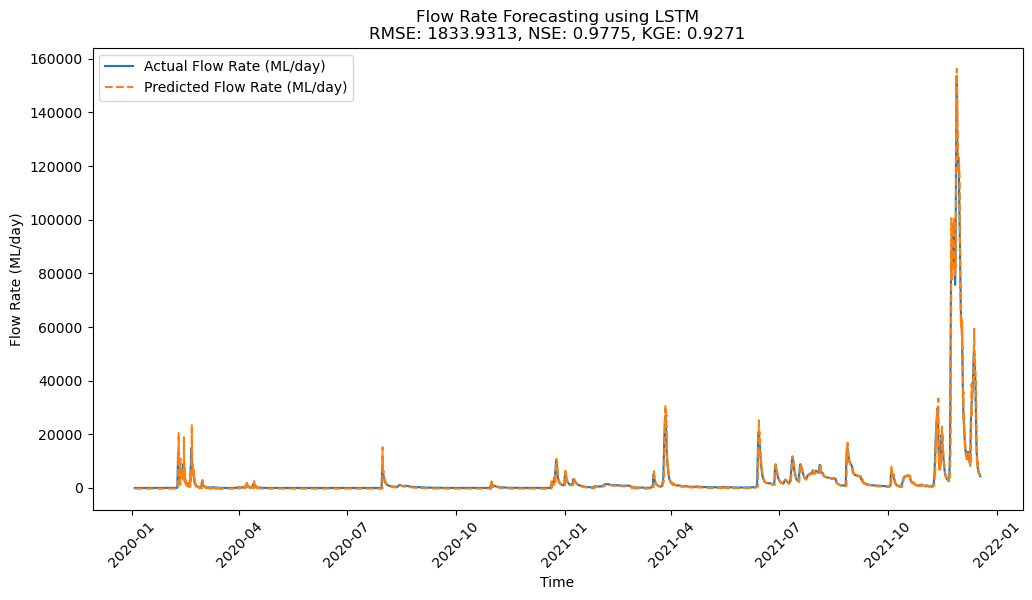

In [2]:

# Example Usage
if __name__ == "__main__":
    file_path = '1256.csv'  # Change if change location
    df = load_data(file_path)
    
    # Set parameters
    window_size = 48 # Change as needed
    lead_time = 16  # Change as needed
    timescale = 1

    # Aggregate into 3 hourly
    #df = aggregate_to_nhourly_last_timestamp(df, timescale)

    X, Y_scaled, Y_unscaled, aligned_dates, scaler = preprocess_data(
    df, column='Varibale Value', window_size=window_size, lead_time=lead_time
    )
    
    # Updated splitting function, expects labels for each sequence

    (
    X_train, X_val, X_test,
    Y_train_scaled, Y_val_scaled, Y_test_scaled,
    Y_train_unscaled, Y_val_unscaled, Y_test_unscaled,
    train_dates, val_dates, test_dates
    ) = train_val_test_split(X, Y_scaled, Y_unscaled, aligned_dates)

    model_path = "lstm_flood_pro10_model2.h5"
    scaler_path = model_path.replace('.h5', '_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    
    # Always build model architecture
    model = build_lstm_model(window_size=window_size, lead_time=lead_time)

    # If trained weights exist, load the _best_val weights, otherwise train and save them
    weights_path = model_path + "_best_val.weights.h5"

    if os.path.exists(weights_path):
        print("Found pre-trained weights, loading:", weights_path)
        model.load_weights(weights_path)
        history = None  # No training, so no history to plot
    else:
        print("Training model...")
        history = train_model(
            model,
            X_train, Y_train_scaled,
            X_val, Y_val_scaled,
            epochs=50,
            batch_size=32,
            model_path=model_path,
            enable_plotting=True    # <-- Enable plotting
        )
    # After training, load the best validation weights
    model.load_weights(weights_path)

    Y_test_predictions  = forecast(model, X_test, scaler)  # Model predicts and inverse transforms
    Y_val_predictions   = forecast(model, X_val, scaler)
    Y_train_predictions = forecast(model, X_train, scaler)

    Y_test_actual_values  = Y_test_unscaled  #  Directly use raw test set values (No inverse transform!)
    Y_val_actual_values   = Y_val_unscaled
    Y_train_actual_values = Y_train_unscaled
    
    plot_results(Y_test_actual_values, Y_test_predictions, test_dates)
    plot_results(Y_val_actual_values, Y_val_predictions, val_dates)
    plot_results(Y_train_actual_values, Y_train_predictions, train_dates)
    
